# Do Batch Processing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

/home/alex/NuMI/PELEE/


In [2]:
# Set False if doing Run 1, True if doing Run 3

isRun3 = True

ending = "Sept19_noTune"

## BNB Sample Histograms - Nue Nue

In [3]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
#full sample
if isRun3 == False:
    NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
elif isRun3 == True:
    NUE  = '/neutrinoselection_filt_run3b_overlay_intrinsic'+ls.APPEND

#actually fetch datasets
nue_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_nue]

nue_variables = ["run", "sub", "evt", "swtrig_pre", "category",             
             "trk_score_v", "topological_score", "shr_score", "shr_px","shr_py","shr_pz",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'nmuon']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz", "proton_e", "elec_e"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)

['trk_score_v', 'slnhits', 'n_showers', 'shr_tkfit_dedx_U', 'shr_energy_cali', 'n_showers_contained', 'sub', 'shr_theta', 'shr_distance', 'n_tracks_contained', 'npi0', 'trk_energy', 'shr_tkfit_dedx_Y', 'shr_py', 'nproton', 'nslice', 'contained_fraction', 'swtrig_pre', 'tksh_angle', 'shr_tkfit_nhits_U', 'shr_pz', 'n_tracks', 'shr_tkfit_nhits_V', 'trkshrhitdist2', 'shr_tkfit_dedx_V', 'reco_nu_vtx_sce_x', 'flash_time', 'ccnc', 'shrsubclusters2', 'shr_tkfit_nhits_Y', 'trk_energy_tot', 'tksh_distance', 'run', 'nu_pdg', 'slnunhits', 'shrsubclusters0', 'evt', 'shr_energy_tot_cali', 'shrmoliereavg', 'shr_tkfit_npoints', 'reco_nu_vtx_sce_z', 'shr_energy', 'category', 'CosmicIPAll3D', 'nmuon', 'topological_score', 'shr_px', 'npion', 'shrsubclusters1', 'reco_nu_vtx_sce_y', 'selected', 'shr_phi', 'shr_score', 'hits_ratio']


In [4]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
#df_v = [nue_nue]
#removeGenieTune = False
#for i,df in enumerate(df_v):
#    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
#    df[ 'currentweight' ] = df['weightSplineTimesTune']
    #print(df['mc_pdg'])

In [5]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_nue]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    #df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    #df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    #df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    #df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    #df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    #df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    #df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    #df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    #df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [6]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)

if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    nue_intrinsic_pot = 2.37838E22 #matches Alex
elif isRun3 == True:
    beamon_pot = 5.014E20 #v5
    nue_intrinsic_pot = 2.5345e+22

nue_nue['pot_scale'] = beamon_pot/nue_intrinsic_pot

In [7]:
nue_nue['totweight_data'] = nue_nue['pot_scale']*nue_nue['ppfx_cv']

In [8]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [9]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [10]:
#These two are the same

#print(df["elec_vx"])
#print(df["true_nu_vtx_x"])

In [11]:
#TRUTH VARIABLE

import time
s = time.time()

for i,df in enumerate(df_v):
    df["elec_px_asmuon"] = np.nan
    df["elec_py_asmuon"] = np.nan
    df["elec_pz_asmuon"] = np.nan
    for j in range(len(df["mc_pdg"])):
        pdg_vector = df["mc_pdg"].iloc[j][0]
        px_vector = df["mc_px"].iloc[j]
        py_vector = df["mc_py"].iloc[j]
        pz_vector = df["mc_pz"].iloc[j]
        result = np.where(pdg_vector==11)[0]
        if np.size(result):
            df.loc[j, "elec_px_asmuon"] = px_vector[result][0]
            df.loc[j, "elec_py_asmuon"] = py_vector[result][0]
            df.loc[j, "elec_pz_asmuon"] = pz_vector[result][0]
            
    print(df["elec_px_asmuon"])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

entry
0         0.335876
1         1.175061
2              NaN
3        -0.178489
4         0.820571
            ...   
124391   -0.001820
124392         NaN
124393    0.602292
124394   -0.016303
124395   -0.219753
Name: elec_px_asmuon, Length: 124396, dtype: float64
time to run:  83.88450980186462


In [12]:
#TRUTH_VARIABLE

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'] + df['elec_pz_asmuon']*df['elec_pz_asmuon'])
    df['targetPt_asmuon']    = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'])
    df['targetTheta_asmuon'] = np.arccos(df['elec_pz_asmuon']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['elec_py_asmuon'],df['elec_px_asmuon'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [13]:
#shr_p

In [14]:
#RECO VARIABLE
#This assumes the electron to be the leading shower
s = time.time()

for i,df in enumerate(df_v):
    df['targetP_asmuon_reco']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    #df['targetPt_asmuon_reco']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    #df['targetTheta_asmuon_reco'] = np.arccos(df['shr_pz']/df['targetP_asmuon_reco'] )
    #df['targetPhi_asmuon_reco']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon_reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['shr_theta'],x['shr_phi']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon_reco'] = np.cos(df['nu_Angle_Numi_Elec_asmuon_reco'])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  4.821781158447266


In [15]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_nue]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  17.985820055007935


In [16]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [17]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    

In [18]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_nue]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"] + df["proton_e"]
    #print(df["proton_e"])

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])


In [19]:
#print(nue_nue.query("true_e <1.1 and is_signal==True"))

In [20]:
# add back the cosmic category, for background only
#df_v = [nue_nue]
#for i,df in enumerate(df_v):
#    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    

In [21]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_nue]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [22]:
#Define signal catagories

#nue_nue["is_signal"] = nue_nue["category"] == 11

In [23]:
# Some quick clean up since some strange events get in there
nue_nue   = nue_nue.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_nue]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    #df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [22]:
#df_v = [nue_nue]
#for i,df in enumerate(df_v):
#    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
#    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
#    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

In [23]:
#reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


#BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
#BDT_PRE_QUERY += ' and ' + reco_in_fv_query
#BDT_PRE_QUERY +=' and contained_fraction>0.9'
#BDT_PRE_QUERY += ' and n_showers_contained==1'
#BDT_PRE_QUERY += ' and n_tracks_contained>0'
#BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
#BDT_LOOSE_CUTS = BDT_PRE_QUERY
#BDT_LOOSE_CUTS +=' and shr_score<0.3'
#BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
#BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
#BDT_LOOSE_CUTS += ' and trkpid<0.35'
#BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [24]:
# load bdt model 
#bdt_model = xgb.Booster({'nthread': 4})
#if isRun3 == False:
#    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
#elif isRun3 == True:
#    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model') 
#    print("Run3.")

In [25]:
# NOW, apply the model to real data for data/MC comparisons

#varlist = [
#    "shr_score", "shrmoliereavg", "trkpid",
#    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
#    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

#datasetlist = [nue_nue]

#for df in datasetlist:
#    for column in varlist:
#        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
#    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
 #   preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
  #  df['BDT_score'] = preds
  #  print(df.shape)

In [26]:
#datasets_bdt = nue_nue

In [27]:
#import matplotlib.pyplot as plt
#import matplotlib

#bins = np.arange(0, 1.0, 0.1)
#gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
#plt.xlabel("BDT Score")
#plt.ylabel("Counts")
#plt.title("Exclusive Nue Selection BDT Scores")
#plt.show()

In [24]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    
    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.cosNu_Angle_Numi_Elec_asmuon>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon <1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco <1.0)
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1
            
#if energy add & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
#if angle add (df.cosNu_Angle_Numi_Elec_asmuon>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon <1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco>-1.0) & (df.cosNu_Angle_Numi_Elec_asmuon_reco <1.0)
#if lepton mom (df.targetP_asmuon>0.04) & (df.targetP_asmuon <5) & (df.targetP_asmuon_reco>0.04) & (df.targetP_asmuon_reco<5)

In [25]:
#NUE_SEL_QUERY = BDT_LOOSE_CUTS
#NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#NUE_SEL_QUERY += ' and true_e > 0.04 and true_e < 5'#

#if isRun3 == False:
#    NUE_SEL_QUERY += ' and BDT_score > 0.55'
#elif isRun3 == True:
#    NUE_SEL_QUERY += ' and BDT_score > 0.575'   

#SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY = 'is_signal==True'

#NOT_SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
#NOT_SIGNAL_NUE_SEL_QUERY += 'and is_signal==False'

In [26]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where( (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [27]:
test = np.nansum(df.query("is_signal==True")['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 723.0873114645253


n_events here =  124396
n_events/2 here =  24879.0

1.0
1
0
124396
{'nue_nue': 0.01978299467350562}
is_signal==True 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_nue
--------------------------------------
current sample is:  nue_nue
[0.55426323 1.1224694  0.7359419  ... 0.49424958 0.87791336 0.95407265]
current_total  723.0873114645252
723.087311464525214432796929031610488891601562500000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  723.0873114645252
723.087311464525214432796929031610488891601562500000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  723.0873114645252
723.087311464525214432796929031610488891601562500000000000000000000000000000000
current_total_split  [723.0873114645252]
current_total_hist  [ 15.52827122  16.13635308  20.030

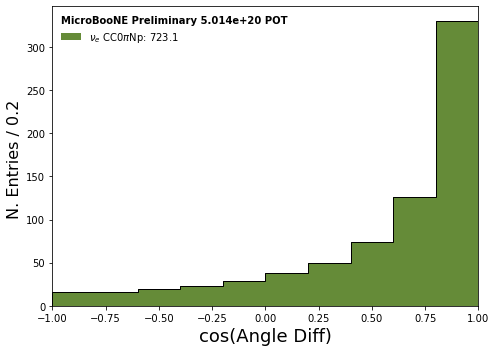

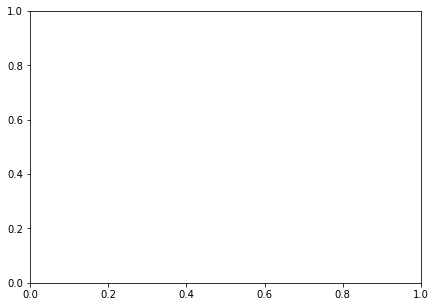

In [28]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/5))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size                     #do this for fist 50

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size   #this is i in standard
    print(start)
    #print(end)
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    print(sample_set.shape[0])
    
    samples = {
        #"nue_nue": nue_nue
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22

    # NUE
    weights = { #full sample mc = 0.38
                "nue_nue"  : nueratio  * SPLIT * scaling
                #"nue_nue"  : 1
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #nue_e to true_e
    #VARIABLE, BINS, RANGE, XTIT = 'true_e',10,(0.0, 5.0),"True Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query = "is_signal==True",
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "ppfx_cv",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)
    

No handles with labels found to put in legend.


723.0873114645248
0.0


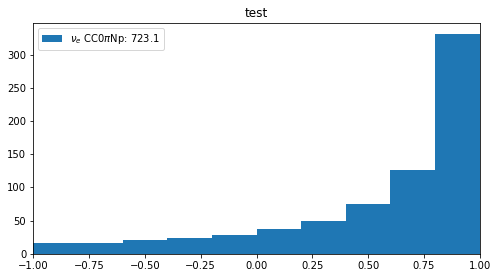

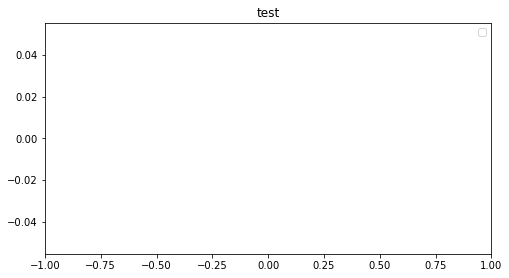

In [32]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()

    print(sum(nue_stacked[0]))

In [33]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

15.528271221096263


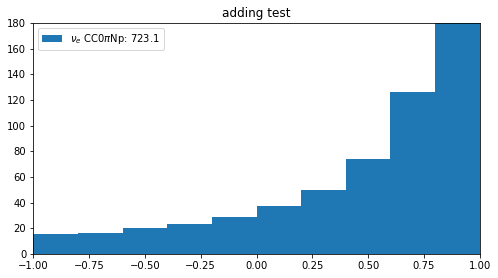

In [34]:
category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
#nue_ax1.set_xlim([0.0, 5.0])
#nue_ax1.set_ylim([0,150])

#AngleDiff
nue_ax1.set_xlim([-1, 1])
nue_ax1.set_ylim([0, 180])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

#print('%.75f' % nue_stacked[0][5])
print(nue_stacked[0][0])

In [35]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [36]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    ######full trueE
    #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    ########angleDiff
    vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_true_angleDiff_'+ending+'.csv')
    weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_true_angleDiff_'+ending+'.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_true_leptonMom_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_true_leptonMom_'+ending+'.csv')
elif isRun3 == True:
    ######full trueE
    #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')

### Stat Errors

In [29]:
# sumw2 of the full event rate 
nuwro_full_sumw2 = []

#RECOE
#xvar = "true_e"
#bins = np.arange(1.0, 4.5, 0.5)
#ANGLE
xvar = "cosNu_Angle_Numi_Elec_asmuon"
bins = np.arange(-1.0, 1.2, 0.2)
#LEPTONMOM
#xvar = "targetP_asmuon"
#bins = np.arange(0, 2.25, 0.25)

#OLD
#RECOE
#xvar = "true_e"
#bins = np.arange(0, 5.5, 0.5)
#LEPTONMOM
#xvar = "targetP_asmuon"
#bins = np.arange(0, 5.5, 0.5)

for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' <= '+str(bins[i+1])
    else: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' < '+str(bins[i+1])

    #nuwro_full_sumw2.append(sum(datasets_bdt['infv'].query('is_signal==True and '+bin_query).totweight_data ** 2) ) #bug (fixed below)
    nuwro_full_sumw2.append(sum(nue_nue.query(SIGNAL_NUE_SEL_QUERY+ " and " +bin_query).totweight_data ** 2))
    
    
# percent stat error - of the background subtracted event rate 
#print( [(np.sqrt(a)/b) for a,b in zip(nuwro_full_sumw2, nuwro_evt_rate)] )
print(nuwro_full_sumw2)

[0.2997659282198284, 0.30211006379811794, 0.37339861727257795, 0.4358111102513419, 0.5353167307589215, 0.7041137148120877, 0.9376083197361244, 1.391777603274976, 2.39489156262057, 6.37637125336897]


In [30]:
if isRun3 == False:
    """
    np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_trueE_recoCut_"+ending+".csv", 
               nuwro_full_sumw2,
               delimiter =", ", 
               fmt ='% s')


    """
    
    #########################
    #####angleDiff###########
    ##########################
    
    np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_true_angleDiff_"+ending+".csv", 
               nuwro_full_sumw2,
               delimiter =", ", 
               fmt ='% s')

    
    
    """
    #########################
    #####leptonMom###########
    ##########################
    
    np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_true_leptonMom_"+ending+".csv", 
               nuwro_full_sumw2,
               delimiter =", ", 
               fmt ='% s')

    """
elif isRun3 == True:
    """
    np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
               nuwro_full_sumw2,
               delimiter =", ", 
               fmt ='% s')

    """
    
    #########################
    #####angleDiff###########
    ##########################
    
    np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
               nuwro_full_sumw2,
               delimiter =", ", 
               fmt ='% s')

    
    
    """
    #########################
    #####leptonMom###########
    ##########################
    
    np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
               nuwro_full_sumw2,
               delimiter =", ", 
               fmt ='% s')

    """

In [37]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'true_e',10,(0.0, 5.0),"True Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,
        query= "is_signal==True",
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "ppfx_cv",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  124396

1.0
1
{'nue_nue': 0.01978299467350562}
is_signal==True 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

current sample is:  nue_nue

current_uncertainties  [  870   925  1151  1332  1659  2169  2869  4280  7216 18424]
self.weights[nue_nue]  0.01978299467350562
LOOK HERE FOR DETSYS
None
err nue: 
[0.34048918 0.36201436 0.45046328 0.52130068 0.64927765 0.84887476
 1.12283157 1.67505024 2.82410339 7.21054336]
detsys nue: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [ 15.528271  16.136353  20.030024  23.296917  28.773432  37.686363
  49.98582   74.36698  126.51077  330.77237 ]
Returning
{'nue_nue': 0.01978299467350562}
is_signal==True 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

current sample is:  nue_nue

current_uncertainties  [0 0 0 0 0 0 0 0 0 0]
self.weights[nue_nue]  0.0

In [38]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

nue_nue_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_nue_stat_errs_selected = total_sels

total errs =  [0.34048918407919804, 0.36201436238305534, 0.4504632768679965, 0.5213006818315997, 0.649277651019988, 0.8488747589284834, 1.1228315737048498, 1.6750502389183535, 2.824103393466084, 7.210543364913959]
total selected =  [15.528270721435547, 16.1363525390625, 20.0300235748291, 23.296916961669922, 28.7734317779541, 37.686363220214844, 49.98582077026367, 74.36698150634766, 126.51077270507812, 330.7723693847656]


In [39]:
if isRun3 == False:
    """
    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_trueE_recoCut_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_trueE_recoCut_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    
    #########################
    #####angleDiff###########
    ##########################
    
    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_true_angleDiff_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_true_angleDiff_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    
    
    """
    #########################
    #####leptonMom###########
    ##########################
    
    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_true_leptonMom_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_true_leptonMom_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
elif isRun3 == True:
    """
    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
    
    #########################
    #####angleDiff###########
    ##########################
    
    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    
    
    """
    #########################
    #####leptonMom###########
    ##########################
    
    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

### Sys Errors - nue nue

In [40]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'true_e',10,(0.0, 5.0),"True Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,
        query= "is_signal==True",
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "ppfx_cv",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  124396

1.0
1
{'nue_nue': 0.01978299467350562}
is_signal==True 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
        0     1    2     3     4     5     6     7     8     9    ...   590  \
0      1391  1068  865  1313  1104  1447  1167  1201  1338  1341  ...  1404   
1       669   226  119   725   196  1688   789  1395   672  1212  ...  1062   
2      1431  1044  819  1334  1086  1501  1160  1198  1365  1369  ...  1447   
3      1240  1075  951  1202  1096  1263  1130  1144  1213  1217  ...  1245   
4      1393  1073  871  1317  1108  1452  1171  1208  1343  1342  ...  1407   
...     ...   ...  ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
40890  1429  1033  809  1329  1075  1502  1150  1189  1360  1364  ...  1445   
40891  1172  1038  932  1141  1055  1190  1083  1093  1150  1154  ...  1176   
40892  1333  1064  881  1270  1095 

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 15.52827072  16.13635254  20.03002548  23.29691315  28.77342987
  37.68636322  49.98582458  74.36698914 126.51077271 330.77233887]


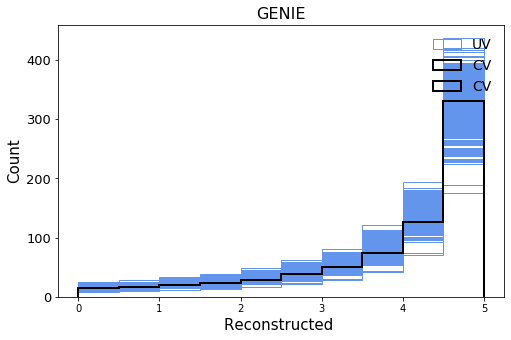

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


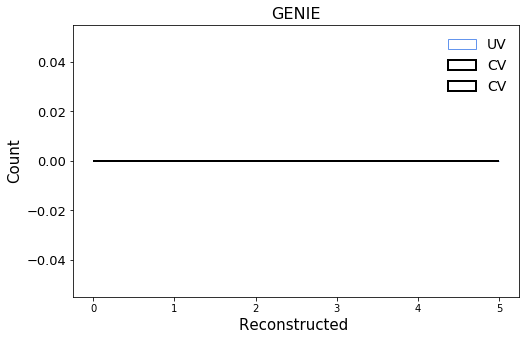

In [41]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    #bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    #bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('GENIE', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    plt.show()

In [42]:
#will need to edit this if batching

nue_nue_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_trueE_usingSelection_recoCut_'+ending+'.csv')
    nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    #nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
elif isRun3 == True:
    #nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_trueE_usingSelection_recoCut_run3_'+ending+'.csv') 
    nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    #nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')

In [43]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_genie.append(sum(masterlist[a]))

final_ncvs_nue_nue_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [44]:
if isRun3 == False:
    """
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_trueE_recoCut_"+ending+".csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_trueE_recoCut_"+ending+".csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    """

    
    #####################
    ###AngleDiff###
    ######################
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_true_angleDiff_"+ending+".csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_true_angleDiff_"+ending+".csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_true_leptonMom_"+ending+".csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_true_leptonMom_"+ending+".csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    """
    
    
    #####################
    ###AngleDiff###
    ######################
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
    """

## Nue_Mc

Unneeded for truth.

## Nue_Dirt

Unneeded for truth.

## Now for Numu

## Numu_Mc

In [3]:
tree = "NeutrinoSelectionFilter"

#presamp
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND
#full
if isRun3 == False:
    NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune
elif isRun3 == True:
    NU   = '/neutrinoselection_filt_run3b_overlay'    +ls.APPEND

numu_mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]


uproot_v = [numu_mc] 

#removed reco_e from here
numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc", "swtrig_pre",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
        "shr_energy_tot_cali", "trk_energy_tot",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score", "elec_e", "proton_e",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]

numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique
numu_variables = list(set(numu_variables))
print(numu_variables)


    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['backtracked_pdg', 'sub', 'ccnc', 'npi0', 'npion', 'slclustfrac', 'trk_mcs_muon_mom_v', 'trk_sce_end_z_v', 'reco_nu_vtx_z', 'interaction', 'nmuon', 'CosmicIPAll3D', 'isVtxInFiducial', 'run', 'nslice', 'reco_nu_vtx_sce_x', 'proton_e', 'slpdg', 'shr_tkfit_dedx_Y', 'mc_pdg', 'category', 'CosmicIP', 'nproton', 'pion_e', 'elec_e', 'trk_energy_tot', 'pi0_e', 'slnunhits', 'trk_phi', 'trk_energy_muon', 'reco_nu_vtx_sce_z', 'trk_llr_pid_score_v', 'CosmicDirAll3D', '_opfilter_pe_beam', 'true_e_visible', 'muon_e', 'reco_nu_vtx_y', 'pi0truth_elec_etot', 'n_showers_contained', 'tksh_distance', 'trk_sce_start_x_v', 'trk_theta', 'reco_nu_vtx_sce_y', 'evt', 'flash_pe', 'reco_nu_vtx_x', 'slnhits', 'shr_energy_tot_cali', '_opfilter_pe_veto', 'trk_sce_end_y_v', 'trk_range_muon_mom_v', 'trk_sce_end_x_v', 'swtrig_pre', 'topological_score', 'nu_pdg', 'evnunhits']


In [4]:
import time
s = time.time()

import pandas as pandas

mc_var   = numu_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX + numu_varMC

# This needs modifications (add variables from above)
uproot_v = [numu_mc] 
var_v    = [mc_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_mc = CVDF

s2 = time.time()

print("runtime = ", s2-s)
#Approx 25 mins R1

trk_llr_pid_v  [[0.73482436] [-0.70503384 0.5525445 -3.4028235e+38] [] ... [] [] [0.9896643 0.5211012 0.04211452]]
trk_score_v  [[0.8417371] [0.9219987 0.9697223 -1.0] [] ... [] [] [1.0 0.011713999 0.47363594]]
Here:
trk_range_muon_mom_v  [[0.2488809] [0.121225685 0.109380074 -3.4028235e+38] [] ... [] [] [1.2258223 0.20158982 0.05128334]]
trk_mcs_muon_mom_v  [[0.27999988] [0.40099838 14.999432 -3.4028235e+38] [] ... [] [] [1.9420298 0.13100009 14.993429]]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


runtime =  1387.5569355487823


In [5]:
df_v = [numu_mc]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [6]:
#numu_mc   = numu_mc.query('(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
# 254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2', inplace=True) nue_e to true_e
numu_mc.query('nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1026 and true_nu_vtx_z > 10 and true_nu_vtx_y < 106 and true_nu_vtx_y > -106 and true_nu_vtx_x < \
 246 and true_nu_vtx_x > 10  and nproton > 0 and npion == 0 and npi0==0', inplace=True)# and true_e > 0.04 and true_e < 5 and reco_e > 0.04 and reco_e < 5, inplace=True)

In [7]:
#df_v = [numu_mc]
#print(df_v)
#removeGenieTune = False
#for i,df in enumerate(df_v):
#    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
#    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [8]:
s = time.time()

df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    #df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    #df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    #df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    #df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    #df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    #df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    #df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    #df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    #df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    #df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    #df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    #df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    #df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    #df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
     # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    
    
s2 = time.time()
print("runtime = ", s2-s)
#Approx 8 mins R1 w/Cut
#Approx 8h for Run3
#Approx 14s for full cut energy
# Approx 11 mins full cut only R1

runtime =  645.2866456508636


In [9]:
#df_v = [numu_mc]
#removeGenieTune = False
#for i,df in enumerate(df_v):
#    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
#    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
#    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
#    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']

In [10]:
#df_v = [numu_mc]
#scaleFlat = 0
#removeGenieTune = False
#for i,df in enumerate(df_v):
#    if scaleFlat == 1:
#        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
#        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
#    elif scaleFlat == 2:
#        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
#        pi0emax = 0.6
#        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
#        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
#    elif scaleFlat == 0:
#        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ]

In [ ]:
if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    overlay_pot =  2.33652E21
elif isRun3 == True:
    beamon_pot = 5.014E20
    overlay_pot =  1.98937e+21    

numu_mc['pot_scale'] = beamon_pot/overlay_pot

In [ ]:
numu_mc['totweight_data'] = numu_mc['pot_scale']*numu_mc['ppfx_cv']
print(numu_mc['totweight_data'])

In [11]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [12]:
df_v = [numu_mc]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [13]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_5225/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  15.208396911621094


In [14]:
#numu_mc["is_signal"]   = numu_mc["category"] == 2
#print(numu_mc["is_signal"])

In [15]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [16]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [17]:
#TRUE VARIABLE
s = time.time()

for i,df in enumerate(df_v):
    df["muon_px"] = df["ccnc"].copy()
    df["muon_py"] = df["ccnc"].copy()
    df["muon_pz"] = df["ccnc"].copy()
    for j, row in df.iterrows():
        pdg_vector = df["mc_pdg"].loc[j][0]
        px_vector = df["mc_px"].loc[j]
        py_vector = df["mc_py"].loc[j]
        pz_vector = df["mc_pz"].loc[j]
        result = np.where(pdg_vector==13)[0]
        if np.size(result):
            df.loc[j, "muon_px"] = px_vector[result][0]
            df.loc[j, "muon_py"] = py_vector[result][0]
            df.loc[j, "muon_pz"] = pz_vector[result][0]   
            
    #print(df["muon_px"])

print("")    
print("==========================")
s2 = time.time()
print("runetime = ", s2-s)
#R1 approx 22 mins
#R3 approx 10 mins


runetime =  1261.924643278122


In [18]:
#TRUE VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta'],x['targetPhi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])

In [19]:
#RECO VARIABLE
s = time.time()

print(df["trk_sce_end_z_v"])

for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_sce_end_z_v"].copy()
    for j, row in df.iterrows():
        if (len(row["muon_mom"]) !=0 ) and (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        elif (len(row["muon_mom"]) == 0 ):
            df.loc[j, "muon_mom"] = 0
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])
print("")
s2 = time.time()
print("runetime = ", s2-s)
#R3 approx 800s

entry
0                      [81.81491]
24         [1037.5295, 977.49664]
37                             []
43                    [864.65314]
45        [1036.8418, 1022.79175]
                   ...           
914695      [705.7803, 686.07965]
914697                [27.493929]
914701                [423.89124]
914702       [279.0503, 367.3379]
914710                         []
Name: trk_sce_end_z_v, Length: 89146, dtype: object
entry
0         0.248881
24        0.743994
37               0
43        0.354054
45        0.854993
            ...   
914695    0.671995
914697     0.25593
914701    0.350999
914702    0.491998
914710           0
Name: muon_mom, Length: 89146, dtype: object

runetime =  1456.5095751285553


In [20]:
#RECO VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['nu_Angle_Numi_Muon_Reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon_Reco'] = np.cos(df['nu_Angle_Numi_Muon_Reco'])

In [21]:
numu_mc   = numu_mc.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
df_v = [numu_mc]
for i,df in enumerate(df_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    #df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [22]:
# for replacing nue CC 
in_AV_query = "-1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8"
nueCC_query = 'abs(nu_pdg)==12 and ccnc==0 and '+in_AV_query

print("# of nueCC in AV in overlay sample = "+str(len(numu_mc.query(nueCC_query))))
len1 = len(numu_mc)

idx = numu_mc.query(nueCC_query).index
numu_mc.drop(idx, inplace=True)
len2 = len(numu_mc) 
print("# of nueCC in AV dropped in overlay = "+str(len1-len2))

# of nueCC in AV in overlay sample = 0
# of nueCC in AV dropped in overlay = 0


In [23]:
df_v = [numu_mc]
for i,df in enumerate(df_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.cosNu_Angle_Numi_Muon>-1.0) & (df.cosNu_Angle_Numi_Muon <1.0) & (df.cosNu_Angle_Numi_Muon_Reco>-1.0) & (df.cosNu_Angle_Numi_Muon_Reco <1.0)
                                     & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                     & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                     & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                     & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1
    
#if energy add & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
#if angle add (df.cosNu_Angle_Numi_Muon>-1.0) & (df.cosNu_Angle_Numi_Muon <1.0) & (df.cosNu_Angle_Numi_Muon_Reco>-1.0) & (df.cosNu_Angle_Numi_Muon_Reco <1.0)
#if lepton momemtum add (df.targetP>0.04) & (df.targetP <5) & (df.muon_mom >0.04) & (df.muon_mom <5)

In [24]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where( (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["nue_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_CC_Npi0']== True), 'category' ] = 3
    df["nue_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['nue_CC_0pi0']== True), 'category' ] = 4
    
    df["nue_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 5
    df["nue_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 6
    
    df["numubar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['numubar_1eNp']== True), 'category' ] = 7
    df["numu_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1), True, False)
    df.loc[ (df['numu_NC']== True), 'category' ] = 8
    df["numu_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['numu_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["numu_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False) , True, False)
    df.loc[ (df['numu_other']== True), 'category' ] = 10
    df["nue_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==12)) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_Npi0']== True), 'category' ] = 11
    df["nue_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==12)) &  (df.npi0==0), True, False)
    df.loc[ (df['nue_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.nue_CC_Npi0==False)
                             & (df.nue_CC_0pi0==False) & (df.nue_NC_Npi0==False) & (df.nue_NC_0pi0==False)
                             & (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False)
                             & (df.numu_other==False) & (df.nue_Npi0==False) & (df.nue_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [25]:
#NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
#and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)\
#and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 \
#and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 \
#and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 \
#and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0"# \
#and n_showers_contained==1 and shr_tkfit_dedx_Y<4 and tksh_distance<5"
#NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#NUMU_SEL_QUERY += ' and true_e > 0.04 and true_e < 5'

#SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY = 'is_signal==True'

#NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
#NOT_SIGNAL_NUMU_SEL_QUERY += 'and is_signal==False'

In [26]:
#print(df['weightsNuMIGeo'][0])

##truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
#truthsel_nue  += " and category == 11"

#truthsel_numu  = "(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
# 254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and npi0 ==0 and true_e > 0.04 and true_e < 5)"
#truthsel_numu  += " and category == 2"
#truthsel_numu += ' and reco_e > 0.04 and reco_e < 5'

n_events here =  89146

1.0
1
{'numu_mc': 0.08559738414394057}
is_signal==True 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_mc
--------------------------------------
current_total  6915.046057614576
6915.046057614576056948862969875335693359375000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  6915.046057614576
6915.046057614576056948862969875335693359375000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  6915.046057614576
6915.046057614576056948862969875335693359375000000000000000000000000000000000000
current_total_split  [6915.046057614576]
current_total_hist  [ 196.51566588  206.50740368  237.26265716  280.84038717  320.29902548
  403.07289641  512.01217083  710.71305847 1162.37139608 2885.45139645]
6915.04605761456

Returni

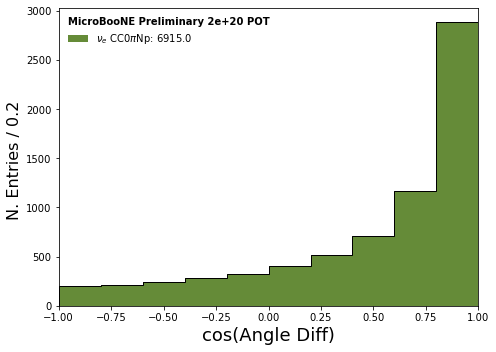

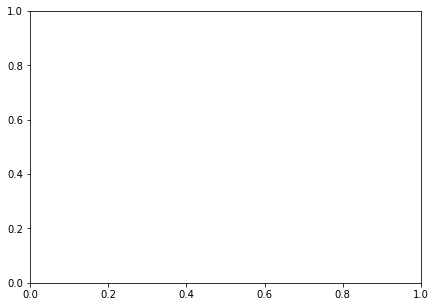

In [25]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21

    
    weights = { #full sample mc = 0.38
                "numu_mc": mcratio  * SPLIT * scaling,
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)

    #Now check on a variable
    #Remember to change the plotter keys between truth and mc

    #nue_e to true_e
    #VARIABLE, BINS, RANGE, XTIT = 'true_e',10,(0.0, 5.0),"True Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= "is_signal==True",
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "ppfx_cv",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    print(len(varss))
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


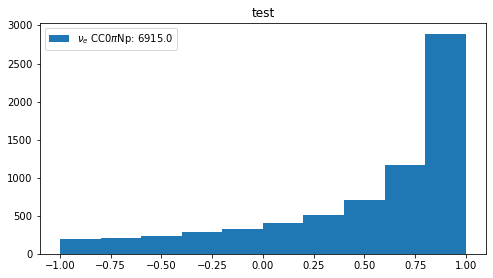

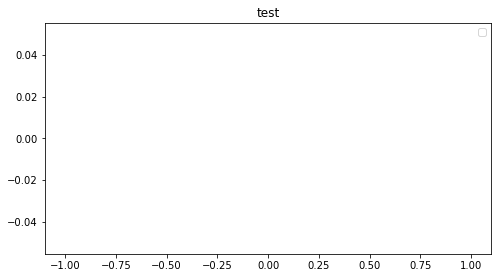

In [26]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])   #trueE, leptonMom
    #nue_ax1.set_xlim([-1, 1])   #angleMuon

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()

In [27]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

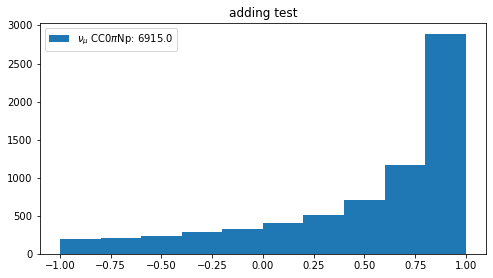

In [28]:
category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#Nu Energy, leptonMom
#nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 4000])
#angleMuon
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 300])
#angleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 3600])


nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [29]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

wanted_key = 4

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)


[]

SUMS
[]
[]

Wanted List:
[]



In [30]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    #full
    #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    #angleDiff
    vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_true_angleDiff_'+ending+'.csv')
    weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_true_angleDiff_'+ending+'.csv')
    #leptonMom
    #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_true_leptonMom_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_true_leptonMom_'+ending+'.csv')
elif isRun3 == True: 
    #full
    #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    #angleDiff
    vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    #leptonMom
    #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
    #weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')

### Stat Errors

In [ ]:
#numumcstaterrs

# sumw2 of the full event rate 
weight_stat_errs = []

#RECOE
#xvar = "true_e"
#bins = np.arange(1.0, 4.5, 0.5)
#ANGLE
xvar = "cosNu_Angle_Numi_Muon"
bins = np.arange(-1.0, 1.2, 0.2)
#LEPTONMOM
#xvar = "targetP"
#bins = np.arange(0, 2.25, 0.25)

#OLD
#RECOE
#xvar = "true_e"
#bins = np.arange(0, 5.5, 0.5)
#LEPTONMOM
#xvar = "targetP"
#bins = np.arange(0, 5.5, 0.5)

for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' <= '+str(bins[i+1])
    else: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' < '+str(bins[i+1])

    #nuwro_full_sumw2.append(sum(datasets_bdt['infv'].query('is_signal==True and '+bin_query).totweight_data ** 2) ) #bug (fixed below)
    weight_stat_errs.append(sum(numu_mc.query(SIGNAL_NUMU_SEL_QUERY+ " and " +bin_query).totweight_data ** 2))
    
    
# percent stat error - of the background subtracted event rate 
#print( [(np.sqrt(a)/b) for a,b in zip(nuwro_full_sumw2, nuwro_evt_rate)] )
print(weight_stat_errs)

In [ ]:
if isRun3 == False:
    """
    np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_trueE_recoCut_"+ending+".csv", 
               weight_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    """
    
    ############################
    #####angleDiff#############
    #############################

    np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_true_angleDiff_"+ending+".csv", 
               weight_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    
    """
    ############################
    #####leptonMom#############
    #############################

    np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_true_leptonMom_"+ending+".csv", 
               weight_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    """
elif isRun3 == True:
    """
    np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
               weight_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    """
    
    ############################
    #####angleDiff#############
    #############################

    np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
               weight_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    
    """
    ############################
    #####leptonMom#############
    #############################

    np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
               weight_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    """

In [31]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21

    
    weights = {
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'true_e',10,(0.0, 5.0),"True Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,
        query= "is_signal==True",
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "ppfx_cv",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  89146

1.0
1
{'numu_mc': 0.08559738414394057}
is_signal==True 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

current sample is:  numu_mc

LOOK HERE FOR DETSYS
None
err numu mc: 
[ 18.60303001  19.7460283   22.88194671  26.86778694  30.74372347
  38.56153876  48.68733138  67.29036139 110.1527976  269.46917587]
detsys numu mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [ 196.51566  206.5074   237.26265  280.8404   320.299    403.07288
  512.01215  710.713   1162.3713  2885.4512 ]
Returning
{'numu_mc': 0.08559738414394057}
is_signal==True 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

current sample is:  numu_mc

LOOK HERE FOR DETSYS
None
err numu mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys numu mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Returnin

In [32]:
#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errors = ", total_errs)

numu_mc_stat_errs = total_errs

#########################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_mc_stat_errs_selected = total_sels

total errors =  [18.603030005432448, 19.746028304308958, 22.88194671404708, 26.867786935770294, 30.74372347490924, 38.56153876273768, 48.68733138483601, 67.29036139026844, 110.15279759813762, 269.4691758723098]
total selected =  [196.51565551757812, 206.5074005126953, 237.2626495361328, 280.84039306640625, 320.29901123046875, 403.0728759765625, 512.0121459960938, 710.7130126953125, 1162.371337890625, 2885.451171875]


In [33]:
if isRun3 == False:
    """
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_trueE_recoCut_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_trueE_recoCut_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
    
    ############################
    #####angleDiff#############
    #############################

    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_true_angleDiff_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_true_angleDiff_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    
    """
    ############################
    #####leptonMom#############
    #############################

    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_true_leptonMom_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_true_leptonMom_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
elif isRun3 == True:
    """
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
    
    ############################
    #####angleDiff#############
    #############################

    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    
    """
    ############################
    #####leptonMom#############
    #############################

    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

## Sys errs - numu mc

In [34]:
#############################
##### weightsgenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'true_e',10,(0.0, 5.0),"True Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,
        query= "is_signal==True",
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "ppfx_cv",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  89146

1.0
1
{'numu_mc': 0.08559738414394057}
is_signal==True 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
        0     1     2     3     4     5     6     7     8     9    ...   590  \
0      1306  1075   929  1245  1104  1333  1148  1155  1259  1276  ...  1314   
1      1235  1016   917  1173  1117  1218  1127  1098  1194  1185  ...  1264   
2      1583  1095   834  1460  1144  1684  1235  1291  1501  1499  ...  1605   
3      1091   379   450  1463  1053   589  1351   477  1563   516  ...  1298   
4      1303  1030   899  1228  1133  1297  1156  1135  1254  1243  ...  1335   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
89119   179    52   146    95    71   339   156   166   210   155  ...   100   
89120  1258  1062  1132  1170  1438  1139  1263  1101  1199  1173  ...  1349   
89121     1     1     1    

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 196.51565552  206.50741577  237.26263428  280.84039307  320.2989502
  403.07287598  512.01208496  710.71313477 1162.37133789 2885.45141602]


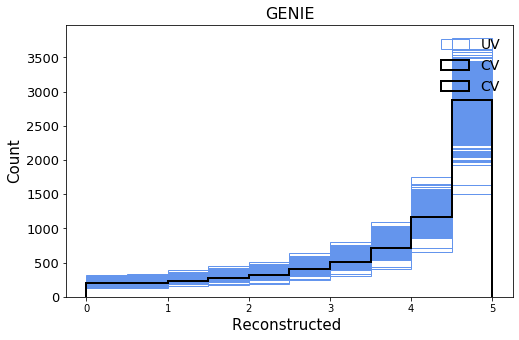

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


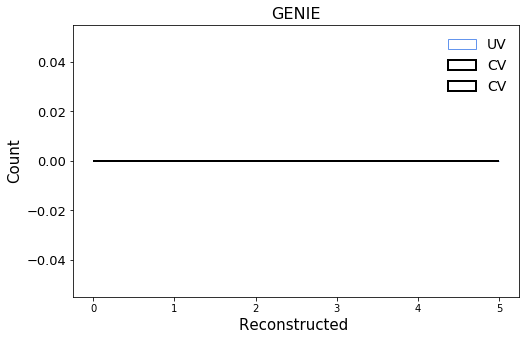

In [35]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    #bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
    #bins = np.arange(-1, 1.2, 0.2)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('GENIE', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    plt.show()

In [36]:
#will need to edit this if batching

numu_mc_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    #numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_trueE_usingSelection_recoCut_'+ending+'.csv')
    numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    #numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
elif isRun3 == True:
    #numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_trueE_usingSelection_recoCut_run3_'+ending+'.csv') 
    numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    #numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')

In [37]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_genie.append(sum(masterlist[a]))

final_ncvs_numu_mc_genie = sum(n_cv_tots)

##################################################

frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [38]:
if isRun3 == False:
    """
    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_trueE_recoCut_"+ending+".csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_trueE_recoCut_"+ending+".csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    """
    
    ###########################
    #####angleDiff###########
    ##########################

    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_true_angleDiff_"+ending+".csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_true_angleDiff_"+ending+".csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    
    """
    ###########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_true_leptonMom_"+ending+".csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_true_leptonMom_"+ending+".csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
    """
elif isRun3 == True:
    """
    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    """
    
    ###########################
    #####angleDiff###########
    ##########################

    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    
    """
    ###########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
    """

## Numu_Dirt

Unneeded for truth.